In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.manifold import TSNE
import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


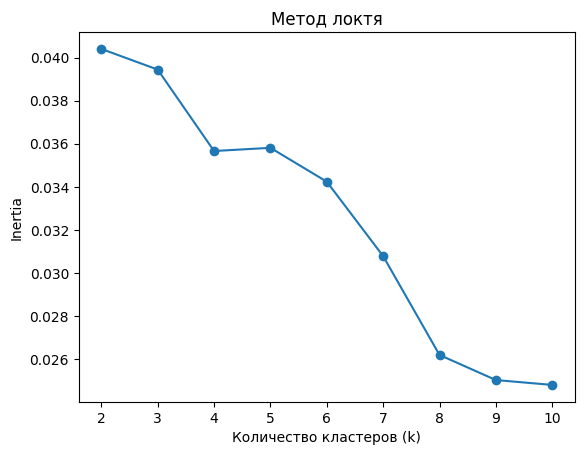

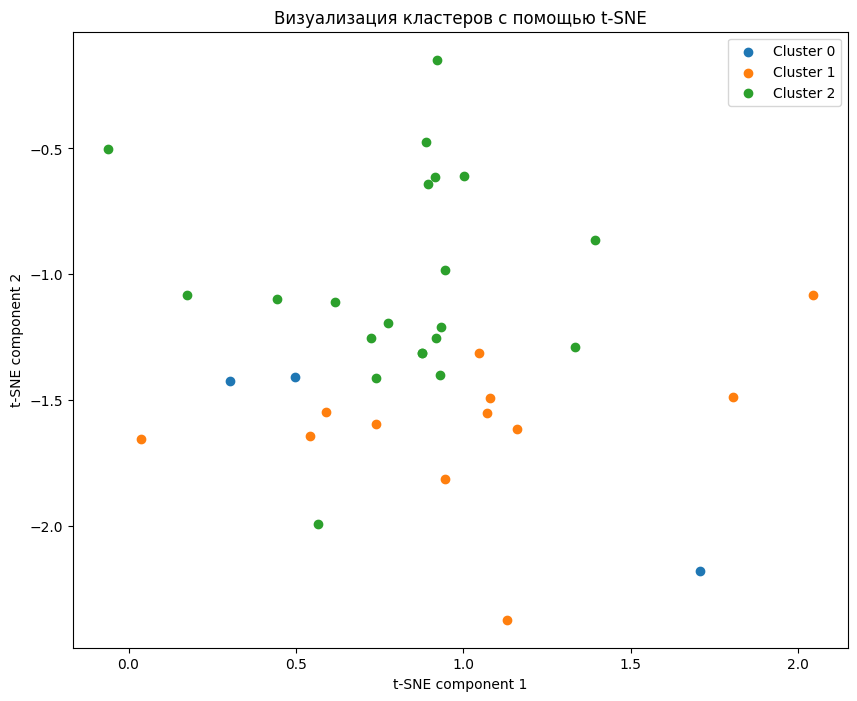

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

# Загрузка данных
df = pd.read_csv("cleaned_museums.csv", encoding='utf-8')


def clean_text(text):
    if pd.isna(text):
        return ""
    original_text = text
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    if text != original_text:
        print("Original:", original_text)
        print("After cleaning:", text)

    return text

# TF-IDF (униграммы и биграммы)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=1,
    stop_words=stopwords.words('russian'),
)


tfidf_matrix = vectorizer.fit_transform(df['Description'].apply(clean_text))


# Word2Vec
sentences = [word_tokenize(text) for text in df['Description'].apply(clean_text)]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Векторизация с tf-idf весами
tfidf_word2vec = np.zeros((len(sentences), 100))
for i, sentence in enumerate(sentences):
    sentence_vec = np.zeros(100)
    weighted_sum = 0
    for word in sentence:
        if word in model.wv and word in vectorizer.vocabulary_:
            word_vec = model.wv[word]
            tfidf_score = tfidf_matrix[i, vectorizer.vocabulary_[word]]
            sentence_vec += word_vec * tfidf_score
            weighted_sum += tfidf_score
    if weighted_sum > 0:
        sentence_vec /= weighted_sum
    tfidf_word2vec[i, :] = sentence_vec

# K-Means
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_word2vec)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.show()

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(tfidf_word2vec)
df['cluster'] = kmeans.labels_

# Визуализация (t-SNE) -  может быть ресурсоемкой для больших датасетов
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_word2vec)

plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(tsne_results[df['cluster'] == i, 0], tsne_results[df['cluster'] == i, 1], label=f'Cluster {i}')
plt.title('Визуализация кластеров с помощью t-SNE')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()

